In [470]:
import csv
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import torch.nn.functional as F

In [416]:
oak_data = pd.read_csv('data.csv')
norl_data = pd.read_csv('new_orleans_data.csv')

/home/alex/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (6,10,22,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/alex/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [417]:
oak_data.head()

,raw_row_number,date,time,location,lat,lng,beat,subject_age,subject_race,subject_sex,...,contraband_weapons,search_conducted,search_basis,reason_for_stop,use_of_force_description,raw_subject_sdrace,raw_subject_resultofencounter,raw_subject_searchconducted,raw_subject_typeofsearch,raw_subject_resultofsearch
0,17213,NaN,01:33:00,E. 28th St. & Park BLVD,37.803084,-122.237247,NaN,NaN,asian/pacific islander,female,...,NaN,False,NaN,Traffic Violation,NaN,A,"Citation,",No,NaN,NaN
1,17214,NaN,14:48:00,1759 SEMINARY AV,37.767568,-122.196820,NaN,NaN,black,male,...,False,True,other,Probation/Parole,NaN,B,"FI Report,",Yes,"Prob./Parole,",NaN
2,1,2013-04-01,00:00:00,31st St And Mlk Jr Way,37.820599,-122.270734,NaN,NaN,white,male,...,False,True,other,Traffic Violation,NaN,W,"Warning,",Yes,"Prob./Parole,",NaN
3,2,2013-04-01,00:01:00,3000 Block Of San Pablo Ave,37.821246,-122.276488,NaN,NaN,black,male,...,NaN,False,NaN,Traffic Violation,NaN,B,"FI Report,",No,NaN,NaN
4,19,2013-04-01,10:41:00,12th St/Broadway,37.802937,-122.271738,NaN,NaN,hispanic,female,...,NaN,False,NaN,Probable Cause,NaN,H,"Citation,",No,NaN,NaN


In [418]:
norl_data.head()

,raw_row_number,date,time,location,lat,lng,district,zone,subject_age,subject_race,...,search_person,search_vehicle,search_basis,reason_for_stop,vehicle_color,vehicle_make,vehicle_model,vehicle_year,raw_actions_taken,raw_subject_race
0,1,2010-01-01,01:11:00,NaN,NaN,NaN,6,E,26.0,black,...,False,False,NaN,TRAFFIC VIOLATION,BLACK,DODGE,CARAVAN,2005.0,NaN,BLACK
1,9087,2010-01-01,01:29:00,NaN,NaN,NaN,7,C,37.0,black,...,False,False,NaN,TRAFFIC VIOLATION,BLUE,NISSAN,MURANO,2005.0,NaN,BLACK
2,9086,2010-01-01,01:29:00,NaN,NaN,NaN,7,C,37.0,black,...,False,False,NaN,TRAFFIC VIOLATION,BLUE,NISSAN,MURANO,2005.0,NaN,BLACK
3,267,2010-01-01,14:00:00,NaN,NaN,NaN,7,I,96.0,black,...,False,False,NaN,TRAFFIC VIOLATION,GRAY,JEEP,GRAND CHEROKEE,2003.0,NaN,BLACK
4,2,2010-01-01,02:06:00,NaN,NaN,NaN,5,D,17.0,black,...,False,False,NaN,CALL FOR SERVICE,NaN,NaN,NaN,NaN,NaN,BLACK


In [419]:
oak_data['search_basis'].value_counts()

other             27402
probable cause    12712
consent            1043
Name: search_basis, dtype: int64

In [420]:
norl_data['search_basis'].value_counts()

other             52863
probable cause    12398
consent            5525
plain view         5005
Name: search_basis, dtype: int64

## Data Cleaning

In [421]:
# These will be the columns our final models use
columns = ['lat', 'lng', 'subject_age', 'subject_race', 'subject_sex', 
           'type', 'outcome', 'search_conducted', 'reason_for_stop']

In [422]:
oak_data.columns


Index(['raw_row_number', 'date', 'time', 'location', 'lat', 'lng', 'beat',
       'subject_age', 'subject_race', 'subject_sex', 'officer_assignment',
       'type', 'arrest_made', 'citation_issued', 'warning_issued', 'outcome',
       'contraband_found', 'contraband_drugs', 'contraband_weapons',
       'search_conducted', 'search_basis', 'reason_for_stop',
       'use_of_force_description', 'raw_subject_sdrace',
       'raw_subject_resultofencounter', 'raw_subject_searchconducted',
       'raw_subject_typeofsearch', 'raw_subject_resultofsearch'],
      dtype='object')

In [423]:
norl_data.columns

Index(['raw_row_number', 'date', 'time', 'location', 'lat', 'lng', 'district',
       'zone', 'subject_age', 'subject_race', 'subject_sex',
       'officer_assignment', 'type', 'arrest_made', 'citation_issued',
       'warning_issued', 'outcome', 'contraband_found', 'contraband_drugs',
       'contraband_weapons', 'frisk_performed', 'search_conducted',
       'search_person', 'search_vehicle', 'search_basis', 'reason_for_stop',
       'vehicle_color', 'vehicle_make', 'vehicle_model', 'vehicle_year',
       'raw_actions_taken', 'raw_subject_race'],
      dtype='object')

In [424]:
oak_clean = oak_data[columns]
norl_clean = norl_data[columns]

In [425]:
oak_clean['outcome'].value_counts(), norl_clean['outcome'].value_counts()

(citation    52426
 warning     30684
 arrest      16190
 Name: outcome, dtype: int64, warning     123832
 citation    117609
 arrest       94164
 Name: outcome, dtype: int64)

### Standardize and One hot encode Reason For Stop

In [426]:
# Created based on https://cao-94612.s3.amazonaws.com/documents/2019-Stop-Data-Annual-Report-6Oct20-Final-Signed-1.pdf 
# and https://nopdnews.com/nopdnews/media/Assets/Policing-Data/Stop-and-Search-annual-report-2015.pdf
# and https://www.voiceofsandiego.org/topics/news/what-it-means-when-police-ask-are-you-on-probation/
reason_for_stop_map = {
    "TRAFFIC VIOLATION": "Traffic Violation",
    "Traffic Violation": "Traffic Violation",
    "CITIZEN CONTACT":   "Consensual Encounter",
    "CRIMINAL VIOLATION":"Probable Cause",
    "CALL FOR SERVICE": "Probable Cause",
    "SUSPECT PERSON" :"Probable Cause",
    "SUSPECT VEHICLE": "Probable Cause",
    "OTHER": "Other",
    "FLAGGED DOWN": "Consensual Encounter",
    "Probation/Parole": "Probable Cause", 
    "JUVENILE VIOLATION": "Probable Cause",
    "PRESENT AT CRIME SCENE": "Probable Cause",
    "Probable Cause": "Probable Cause",
    "Reasonable Suspicion": "Probable Cause",
    "Other": "Other",
    "Consensual Encounter": "Consensual Encounter",
    "Other-Consensual,": "Other",
    "Probable Cause,": "Probable Cause",
    
}
for i in set(oak_data['reason_for_stop']) | set(norl_data['reason_for_stop']):
    for j in i.split("|"):
        if j not in reason_for_stop_map:
            print(i, j)
print(set(reason_for_stop_map.values()))


{'Other', 'Probable Cause', 'Consensual Encounter', 'Traffic Violation'}


In [427]:
reason_for_stop_values = list(sorted(set(reason_for_stop_map.values())))
def reason_for_stop_clean(entries):
    res = [0, 0, 0, 0]
    for entry in entries.split("|"):
        mapped = reason_for_stop_map[entry]
        res[reason_for_stop_values.index(mapped)] = 1
    return np.array(res)
norl_clean['reason_for_stop'] = norl_data['reason_for_stop'].apply(reason_for_stop_clean)
norl_clean['reason_for_stop'].apply(tuple).value_counts()

/home/alex/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(0, 0, 0, 1)    292318
(0, 0, 1, 0)    174861
(0, 1, 0, 0)     24528
(1, 0, 0, 0)     20378
(0, 0, 1, 1)         5
(0, 1, 0, 1)         2
Name: reason_for_stop, dtype: int64

In [428]:
oak_clean['reason_for_stop'] = oak_data['reason_for_stop'].apply(reason_for_stop_clean)
oak_clean['reason_for_stop'].apply(tuple).value_counts()

/home/alex/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(0, 0, 0, 1)    99847
(0, 0, 1, 0)    29306
(1, 0, 0, 0)     3998
(0, 0, 1, 1)      153
(1, 0, 1, 0)       69
(1, 0, 0, 1)       33
(0, 1, 0, 0)        1
Name: reason_for_stop, dtype: int64

In [429]:
oak_clean[reason_for_stop_values] = pd.DataFrame(np.stack(np.array(oak_clean['reason_for_stop'].values), axis=0))
oak_clean.head()

/home/alex/.local/lib/python3.5/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,lat,lng,subject_age,subject_race,subject_sex,type,outcome,search_conducted,reason_for_stop,Consensual Encounter,Other,Probable Cause,Traffic Violation
0,37.803084,-122.237247,NaN,asian/pacific islander,female,vehicular,citation,False,"[0, 0, 0, 1]",0,0,0,1
1,37.767568,-122.196820,NaN,black,male,NaN,NaN,True,"[0, 0, 1, 0]",0,0,1,0
2,37.820599,-122.270734,NaN,white,male,vehicular,warning,True,"[0, 0, 0, 1]",0,0,0,1
3,37.821246,-122.276488,NaN,black,male,vehicular,NaN,False,"[0, 0, 0, 1]",0,0,0,1
4,37.802937,-122.271738,NaN,hispanic,female,NaN,citation,False,"[0, 0, 1, 0]",0,0,1,0


In [430]:
norl_clean[reason_for_stop_values] = pd.DataFrame(np.stack(np.array(norl_clean['reason_for_stop'].values), axis=0))
norl_clean.head()

,lat,lng,subject_age,subject_race,subject_sex,type,outcome,search_conducted,reason_for_stop,Consensual Encounter,Other,Probable Cause,Traffic Violation
0,NaN,NaN,26.0,black,female,vehicular,NaN,False,"[0, 0, 0, 1]",0,0,0,1
1,NaN,NaN,37.0,black,male,vehicular,NaN,False,"[0, 0, 0, 1]",0,0,0,1
2,NaN,NaN,37.0,black,male,vehicular,NaN,False,"[0, 0, 0, 1]",0,0,0,1
3,NaN,NaN,96.0,black,male,vehicular,NaN,False,"[0, 0, 0, 1]",0,0,0,1
4,NaN,NaN,17.0,black,male,NaN,NaN,False,"[0, 0, 1, 0]",0,0,1,0


In [431]:
norl_clean = norl_clean.drop(columns=['reason_for_stop'])
oak_clean = oak_clean.drop(columns=['reason_for_stop'])

### Take care of NA's

In [432]:
oak_clean.isna().sum()

lat                        114
lng                        114
subject_age             102724
subject_race                 0
subject_sex                 90
type                     20066
outcome                  34107
search_conducted             0
Consensual Encounter         0
Other                        0
Probable Cause               0
Traffic Violation            0
dtype: int64

In [433]:
norl_clean.isna().sum()

lat                     251684
lng                     251684
subject_age              12786
subject_race             11730
subject_sex              11730
type                    149907
outcome                 176487
search_conducted             0
Consensual Encounter         0
Other                        0
Probable Cause               0
Traffic Violation            0
dtype: int64

In [434]:
norl_clean = norl_clean.dropna(subset=["subject_race","subject_sex", "type", "outcome"]).reset_index(drop=True)
oak_clean = oak_clean.dropna(subset=["subject_race","subject_sex", "type", "outcome"]).reset_index(drop=True)


In [435]:
def set_mean_to_avg(frame, column):
    frame[column] = frame[column].fillna(frame[column].mean())

set_mean_to_avg(oak_clean, 'subject_age')
set_mean_to_avg(oak_clean, 'lat')
set_mean_to_avg(oak_clean, 'lng')

set_mean_to_avg(norl_clean, 'subject_age')
set_mean_to_avg(norl_clean, 'lat')
set_mean_to_avg(norl_clean, 'lng')


In [436]:
oak_clean.isna().sum(), oak_clean.shape

(lat                     0
 lng                     0
 subject_age             0
 subject_race            0
 subject_sex             0
 type                    0
 outcome                 0
 search_conducted        0
 Consensual Encounter    0
 Other                   0
 Probable Cause          0
 Traffic Violation       0
 dtype: int64, (88826, 12))

In [437]:
norl_clean.isna().sum(), norl_clean.shape

(lat                     0
 lng                     0
 subject_age             0
 subject_race            0
 subject_sex             0
 type                    0
 outcome                 0
 search_conducted        0
 Consensual Encounter    0
 Other                   0
 Probable Cause          0
 Traffic Violation       0
 dtype: int64, (253930, 12))

### Rest of one hot encoding

In [438]:
oak_clean['outcome'] = ((oak_clean['outcome'] == 'citation') | (oak_clean['outcome'] == 'arrest')).astype(int)
norl_clean['outcome'] = ((norl_clean['outcome'] == 'citation') | (norl_clean['outcome'] == 'arrest')).astype(int)


In [439]:
oak_clean['search_conducted'] = oak_clean['search_conducted'].astype('int')
norl_clean['search_conducted'] = norl_clean['search_conducted'].astype('int')

In [440]:
oak_clean.head()

,lat,lng,subject_age,subject_race,subject_sex,type,outcome,search_conducted,Consensual Encounter,Other,Probable Cause,Traffic Violation
0,37.803084,-122.237247,33.893728,asian/pacific islander,female,vehicular,1,0,0,0,0,1
1,37.820599,-122.270734,33.893728,white,male,vehicular,0,1,0,0,0,1
2,37.815760,-122.285080,33.893728,black,male,vehicular,1,1,0,0,0,1
3,37.759561,-122.186857,33.893728,black,male,vehicular,1,0,0,0,0,1
4,37.754716,-122.186500,33.893728,hispanic,female,vehicular,0,0,0,0,0,1


In [441]:
oak_clean['type'] = (oak_clean['type'] == 'vehicular').astype(int)
oak_clean['subject_sex'] = (oak_clean['subject_sex'] == 'female').astype(int)

norl_clean['type'] = (norl_clean['type'] == 'vehicular').astype(int)
norl_clean['subject_sex'] = (norl_clean['subject_sex'] == 'female').astype(int)



In [442]:
oak_clean.head()

,lat,lng,subject_age,subject_race,subject_sex,type,outcome,search_conducted,Consensual Encounter,Other,Probable Cause,Traffic Violation
0,37.803084,-122.237247,33.893728,asian/pacific islander,1,1,1,0,0,0,0,1
1,37.820599,-122.270734,33.893728,white,0,1,0,1,0,0,0,1
2,37.815760,-122.285080,33.893728,black,0,1,1,1,0,0,0,1
3,37.759561,-122.186857,33.893728,black,0,1,1,0,0,0,0,1
4,37.754716,-122.186500,33.893728,hispanic,1,1,0,0,0,0,0,1


In [443]:
races = list(sorted(set(oak_clean['subject_race']) | set(norl_clean['subject_race'])))
races

['asian/pacific islander', 'black', 'hispanic', 'other', 'unknown', 'white']

In [444]:
def race_clean(entry):
    res = [0] * len(races)
    res[races.index(entry)] = 1
    return res
oak_clean[races] = pd.DataFrame(np.stack(np.array(oak_clean['subject_race'].apply(race_clean).values), axis=0))
norl_clean[races] = pd.DataFrame(np.stack(np.array(norl_clean['subject_race'].apply(race_clean).values), axis=0))

oak_clean = oak_clean.drop(columns=['subject_race'])
norl_clean = norl_clean.drop(columns=['subject_race'])


In [445]:
norl_clean.head()

,lat,lng,subject_age,subject_sex,type,outcome,search_conducted,Consensual Encounter,Other,Probable Cause,Traffic Violation,asian/pacific islander,black,hispanic,other,unknown,white
0,29.960841,-90.057711,35.0,1,1,1,0,0,0,0,1,0,1,0,0,0,0
1,29.962113,-90.066910,26.0,1,1,1,0,0,0,0,1,0,0,0,0,0,1
2,29.963036,-90.112752,27.0,0,1,0,1,0,0,0,1,0,1,0,0,0,0
3,29.960841,-90.057711,19.0,1,1,1,0,0,0,0,1,0,0,0,0,0,1
4,29.961357,-90.099890,67.0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


In [446]:
oak_clean.isna().sum(), oak_clean.shape

(lat                       0
 lng                       0
 subject_age               0
 subject_sex               0
 type                      0
 outcome                   0
 search_conducted          0
 Consensual Encounter      0
 Other                     0
 Probable Cause            0
 Traffic Violation         0
 asian/pacific islander    0
 black                     0
 hispanic                  0
 other                     0
 unknown                   0
 white                     0
 dtype: int64, (88826, 17))

In [447]:
norl_clean.isna().sum(), norl_clean.shape

(lat                       0
 lng                       0
 subject_age               0
 subject_sex               0
 type                      0
 outcome                   0
 search_conducted          0
 Consensual Encounter      0
 Other                     0
 Probable Cause            0
 Traffic Violation         0
 asian/pacific islander    0
 black                     0
 hispanic                  0
 other                     0
 unknown                   0
 white                     0
 dtype: int64, (253930, 17))

In [448]:
oak_clean.describe()

,lat,lng,subject_age,subject_sex,type,outcome,search_conducted,Consensual Encounter,Other,Probable Cause,Traffic Violation,asian/pacific islander,black,hispanic,other,unknown,white
count,88826.000000,88826.000000,88826.000000,88826.000000,88826.000000,88826.000000,88826.000000,88826.000000,88826.0,88826.000000,88826.000000,88826.000000,88826.000000,88826.000000,88826.000000,88826.0,88826.000000
mean,37.787540,-122.228409,33.893728,0.260194,0.948303,0.670052,0.236034,0.005877,0.0,0.087835,0.908090,0.066546,0.556886,0.217042,0.036712,0.0,0.122813
std,0.028087,0.043129,7.017404,0.438743,0.221415,0.470197,0.424646,0.076434,0.0,0.283056,0.288901,0.249235,0.496756,0.412234,0.188055,0.0,0.328224
min,37.491195,-122.469412,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,37.765803,-122.268980,33.893728,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,37.785837,-122.228761,33.893728,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000
75%,37.808883,-122.191335,33.893728,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000
max,38.037528,-119.249135,95.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


In [449]:
norl_clean.describe()

,lat,lng,subject_age,subject_sex,type,outcome,search_conducted,Consensual Encounter,Other,Probable Cause,Traffic Violation,asian/pacific islander,black,hispanic,other,unknown,white
count,253930.000000,253930.000000,253930.000000,253930.000000,253930.000000,253930.000000,253930.000000,253930.0,253930.0,253930.000000,253930.000000,253930.000000,253930.000000,253930.000000,253930.000000,253930.000000,253930.00000
mean,29.969401,-90.063059,35.169625,0.326917,0.904694,0.571472,0.141358,0.0,0.0,0.104777,0.895223,0.009837,0.694046,0.030524,0.000870,0.009353,0.25537
std,0.027999,0.036682,13.141811,0.469088,0.293637,0.494866,0.348391,0.0,0.0,0.306266,0.306266,0.098695,0.460811,0.172025,0.029488,0.096258,0.43607
min,29.656656,-93.196423,10.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,29.953433,-90.084219,25.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,29.969401,-90.063059,32.000000,0.000000,1.000000,1.000000,0.000000,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000
75%,29.973591,-90.056325,44.000000,1.000000,1.000000,1.000000,0.000000,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000
max,30.283410,-89.740142,107.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


## Test Train Split

In [450]:
inputs = list(oak_clean.columns)
label = 'outcome'
inputs.remove(label)
print(inputs)

['lat', 'lng', 'subject_age', 'subject_sex', 'type', 'search_conducted', 'Consensual Encounter', 'Other', 'Probable Cause', 'Traffic Violation', 'asian/pacific islander', 'black', 'hispanic', 'other', 'unknown', 'white']


In [452]:
X_oak = oak_clean[inputs]
y_oak = oak_clean[label]

X_train_oak, X_test_oak, y_train_oak, y_test_oak = train_test_split(X_oak, y_oak, test_size=0.1, random_state=42)

X_norl = norl_clean[inputs]
y_norl = norl_clean[label]


X_train_norl, X_test_norl, y_train_norl, y_test_norl = train_test_split(X_norl, y_norl, test_size=0.1, random_state=42)


## Models

### Linear Model

In [453]:
LinRegOak = LinearRegression().fit(X_train_oak, y_train_oak)

print("Linear Regression Oakland")
print("train accuracy: ",  np.mean((LinRegOak.predict(X_train_oak) > .5) == y_train_oak))
print("test accuracy: ", np.mean((LinRegOak.predict(X_test_oak) > .5) == y_test_oak))

LinRegNorl = LinearRegression().fit(X_train_norl, y_train_norl)

print("Linear Regression New Orleans")
print("train accuracy: ",  np.mean((LinRegNorl.predict(X_train_norl) > .5) == y_train_norl))
print("test accuracy: ", np.mean((LinRegNorl.predict(X_test_norl) > .5) == y_test_norl))

Linear Regression Oakland
train accuracy:  0.6691517706365786
test accuracy:  0.6807384892491275
Linear Regression New Orleans
train accuracy:  0.608365385036121
test accuracy:  0.6049304926554562


### Tree Model

In [464]:
xgbrOak = xgb.XGBClassifier(learning_rate = .15, booster = "gbtree", max_depth = 15, eta = 0.5, n_estimators = 150) 
xgbrOak.fit(X_train_oak, y_train_oak)

print("Gradient Boosting Oakland")
print("train accuracy: ",  np.mean(xgbrOak.predict(X_train_oak) == y_train_oak))
print("test accuracy: ", np.mean(xgbrOak.predict(X_test_oak) == y_test_oak))

Gradient Boosting Oakland
train accuracy:  0.8169820997460691
test accuracy:  0.70145221209051


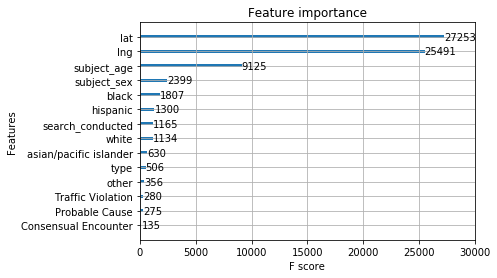

In [465]:
plot_importance(xgbrOak)
plt.show()

In [466]:
xgbrNorl = xgb.XGBClassifier(learning_rate = .1, booster = "gbtree", max_depth = 15, eta = 0.5, n_estimators = 150) 
xgbrNorl.fit(X_train_norl, y_train_norl)

print("Gradient Boosting Oakland")
print("train accuracy: ",  np.mean(xgbrNorl.predict(X_train_norl) == y_train_norl))
print("test accuracy: ", np.mean(xgbrNorl.predict(X_test_norl) == y_test_norl))

Gradient Boosting Oakland
train accuracy:  0.7466230851021936
test accuracy:  0.6578978458630331


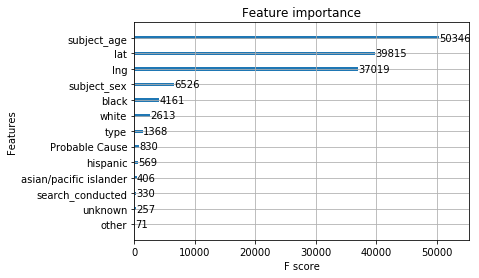

In [467]:
plot_importance(xgbrNorl)
plt.show()

In [469]:
print("GB Oakland cop in New Orleans test accuracy: ", np.mean(xgbrOak.predict(X_test_norl) == y_test_norl))
print("GB New Orleans cop in Oakland test accuracy: ", np.mean(xgbrNorl.predict(X_test_oak) == y_test_oak))


Oakland cop in New Orleans test accuracy:  0.566809750718702
New Orleans cop in Oakland test accuracy:  0.6818642350557245


### Nueral Network